In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [132]:
labels_df = pd.read_csv('data/secom_labels.data', sep=' ', header = None)
labels_df.columns = ['Label', 'Date']
labels_df['Date'] = pd.to_datetime(labels_df['Date'], format = "%d/%m/%Y %H:%M:%S")
print('labels_df shape = {}'.format(labels_df.shape))
labels_df.head()

labels_df shape = (1567, 2)


,Label,Date
0,-1,2008-07-19 11:55:00
1,-1,2008-07-19 12:32:00
2,1,2008-07-19 13:17:00
3,-1,2008-07-19 14:43:00
4,-1,2008-07-19 15:22:00


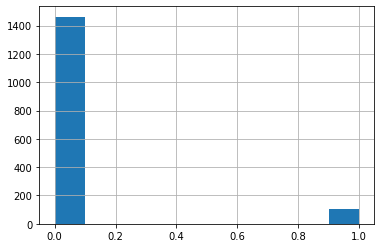

In [76]:
labels_df['Label'] = labels_df['Label'].apply(lambda x: 0 if x == -1 else 1)
labels_df['Label'].hist()

In [77]:
label_sum = labels_df['Label'].groupby(labels_df['Date'].dt.date).sum().reset_index()
label_count = labels_df['Label'].groupby(labels_df['Date'].dt.date).count().reset_index()
label_day = pd.merge(label_sum, label_count, on='Date')
label_day.columns = ['Date', 'Sum', 'Count']
label_day['Date'] = pd.to_datetime(label_day['Date'])
label_day.head()

,Date,Sum,Count
0,2008-07-19,3,12
1,2008-07-20,0,1
2,2008-07-21,1,2
3,2008-07-22,0,6
4,2008-07-23,0,2


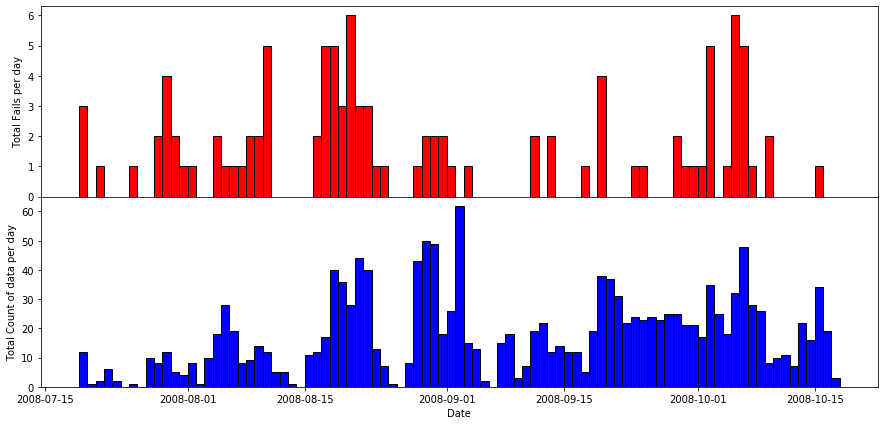

In [85]:
# Create a figure with shared X axis
fig, axs = plt.subplots(2, 1, sharex=True, figsize = (15,7))

# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)

# Set the width of the bars to be 1 day
width = np.timedelta64(1, 'D')

# Plot the Sum of fails per day and count of entries per day
axs[0].bar(label_day['Date'], label_day['Sum'], color = 'red', edgecolor = 'black', width = width)
axs[1].bar(label_day['Date'], label_day['Count'], color = 'blue', edgecolor = 'black', width = width)
axs[0].set_ylabel('Total Fails per day')
axs[1].set_ylabel('Total Count of data per day')
axs[1].set_xlabel('Date');

In [133]:
data_df = pd.read_csv('data/secom.data', sep=' ', header = None)
print('data_df shape = {}'.format(data_df.shape))
data_df.head()

data_df shape = (1567, 590)


,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
3,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
4,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


In [48]:
data_df_missing_count = data_df.isna().sum()
data_df_missing_count[data_df_missing_count > 100].sort_values(ascending = False)

293    1429
157    1429
158    1429
292    1429
85     1341
492    1341
220    1341
358    1341
517    1018
516    1018
384    1018
383    1018
382    1018
245    1018
246    1018
518    1018
244    1018
111    1018
110    1018
109    1018
580     949
581     949
579     949
578     949
72      794
346     794
73      794
345     794
247     715
112     715
385     715
519     715
568     273
563     273
567     273
566     273
569     273
565     273
564     273
562     273
547     260
546     260
556     260
555     260
554     260
553     260
552     260
551     260
550     260
549     260
548     260
557     260
dtype: int64

In [54]:
labels_df.shape

(1567, 2)

In [87]:
split_date = '2008-10-01'
y_train = labels_df['Label'][labels_df['Date'] < split_date]
y_test = labels_df['Label'][labels_df['Date'] >= split_date]

In [96]:
X_train = data_df.loc[y_train.index]
X_test = data_df.loc[y_test.index]

In [97]:
print('X_train, y_train, X_test, y_test shapes: {}, {}, {}, {}'\
      .format(X_train.shape, y_train.shape, X_test.shape, y_test.shape))

X_train, y_train, X_test, y_test shapes: (1208, 590), (1208,), (359, 590), (359,)


In [124]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn import metrics
from imblearn.over_sampling import SMOTE

In [125]:
imp = SimpleImputer(strategy='mean')
imp = imp.fit(X_train)

X_train_imp = imp.transform(X_train)
X_test_imp = imp.transform(X_test)

In [127]:
smt = SMOTE()
X_train_imp_smt, y_train_smt = smt.fit_sample(X_train_imp, y_train)

In [119]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [130]:
names = ["Random Forest"]

classifiers = [RandomForestClassifier()]

In [ ]:
for name, clf in zip(names, classifiers):
    clf.fit(X_train_imp_smt, y_train_smt)
    y_pred = clf.predict(X_train_imp_smt)
    fpr, tpr, thresholds = metrics.roc_curve(y_train_smt, y_pred, pos_label=2)
    print('{} train AUC: {}'.format(name, metrics.auc(fpr, tpr)))
    y_pred = clf.predict(X_test_imp)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=2)
    print('{} test AUC: {}\n'.format(name, metrics.auc(fpr, tpr)))